<a href="https://colab.research.google.com/github/Marcos-CT/Proyecto-Tifon/blob/feature%2Feda-marcos/modelo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
#@title 🔀 Setup del proyecto usando una rama concreta
import sys, subprocess, shutil
from pathlib import Path

REPO_URL = "https://github.com/Marcos-CT/Proyecto-Tifon.git"
PROJECT_DIR = Path("/content/Proyecto-Tifon")
SRC_DIR = PROJECT_DIR / "src"
BRANCH = "feature/eda-marcos"  # ← PON AQUÍ TU RAMA

def run(cmd):
    print("➜", " ".join(cmd))
    return subprocess.run(cmd, check=False, text=True)

# 1) Clonar si hace falta
if PROJECT_DIR.exists() and not (PROJECT_DIR/".git").exists():
    shutil.rmtree(PROJECT_DIR, ignore_errors=True)
if not PROJECT_DIR.exists():
    run(["git", "clone", REPO_URL, str(PROJECT_DIR)])

# 2) Cambiar a la rama deseada
run(["git", "-C", str(PROJECT_DIR), "fetch", "origin", "--prune"])
# crea la rama local basada en la remota si no existe, o cámbiate si ya existe
run(["git", "-C", str(PROJECT_DIR), "checkout", "-B", BRANCH, f"origin/{BRANCH}"])
run(["git", "-C", str(PROJECT_DIR), "pull", "--ff-only"])

# 3) Instalar dependencias
req = PROJECT_DIR / "requirements.txt"
if req.exists():
    run([sys.executable, "-m", "pip", "install", "-q", "-r", str(req)])

# 4) Añadir src al path
if SRC_DIR.exists():
    sys.path.append(str(SRC_DIR))
    print("PYTHONPATH ✔", SRC_DIR)

# 5) Mostrar rama y último commit (para verificar)
run(["git", "-C", str(PROJECT_DIR), "rev-parse", "--abbrev-ref", "HEAD"])
run(["git", "-C", str(PROJECT_DIR), "log", "-1", "--oneline"])

print("✅ Proyecto listo en:", PROJECT_DIR)


➜ git -C /content/Proyecto-Tifon fetch origin --prune
➜ git -C /content/Proyecto-Tifon checkout -B feature/eda-marcos origin/feature/eda-marcos
➜ git -C /content/Proyecto-Tifon pull --ff-only
➜ /usr/bin/python3 -m pip install -q -r /content/Proyecto-Tifon/requirements.txt
PYTHONPATH ✔ /content/Proyecto-Tifon/src
➜ git -C /content/Proyecto-Tifon rev-parse --abbrev-ref HEAD
➜ git -C /content/Proyecto-Tifon log -1 --oneline
✅ Proyecto listo en: /content/Proyecto-Tifon


# ============================================================
# Pipeline limpio: Stacking (RF) + MLP multi-cabeza (Keras)
# y0,y1 -> log-space; y2,y3 -> original
# ============================================================
# Autor: Marcos
# Fecha/hora (CET): 2025-11-13 12:40
# ============================================================

In [38]:
#----------------------------Importamos librerías----------------------------
from google.colab import drive
import os  # manejo de rutas y directorios
import pickle  # para guardar/leer objetos Python
import joblib  # para guardar/leer modelos sklearn
import numpy as np  # numérico base
import pandas as pd  # manejo de tablas/CSV
import matplotlib.pyplot as plt  # diagnósticos visuales (opcional)

import tensorflow as tf  # framework de deep learning
from tensorflow import keras  # API de alto nivel
from tensorflow.keras import layers  # capas de Keras

from sklearn.model_selection import train_test_split, KFold  # split y validación cruzada
from sklearn.preprocessing import StandardScaler, PolynomialFeatures  # escalado y (opcional) polinomios
from sklearn.impute import SimpleImputer  # imputación de X
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error  # métricas clásicas
from sklearn.ensemble import RandomForestRegressor  # profesor para stacking

In [39]:
#----------------------------Montamos drive y cargamos la base de datos----------------------------
drive.mount('/content/drive', force_remount=True)
DATA_DIR = "/content/drive/MyDrive/TIFON/"
df = pd.read_csv(f"{DATA_DIR}base_datos.csv")
print(df.shape)
display(df.head())
list(df.columns)

Mounted at /content/drive
(9999, 7)


,R,Fmax,a,N,SIF,x,y
0,0.0,62.491014,5.0,0.000000,174.730000,-20.000000,0.000000
1,0.0,62.491014,7.0,223713.790360,213.196004,-18.000000,0.000000
2,0.0,62.491014,9.0,344443.709373,243.796017,-16.000000,-0.000765
3,0.0,62.491014,11.0,424105.033144,267.816054,-14.000001,-0.002973
4,0.0,62.491014,13.0,483635.120072,299.968108,-12.000007,-0.007716


['R', 'Fmax', 'a', 'N', 'SIF', 'x', 'y']

In [40]:
#----------------------------Establecemos reproducibilidad----------------------------
SEED = 42  # fija la semilla de aleatoriedad
np.random.seed(SEED)  # semilla numpy
tf.random.set_seed(SEED)  # semilla tensorflow

print("TensorFlow:", tf.__version__)  # mostrar versión por trazabilidad


TensorFlow: 2.19.0


In [41]:
#----------------------------Preparamos los datos----------------------------
drive.mount('/content/drive', force_remount=True)
DATA_DIR = "/content/drive/MyDrive/TIFON/"
df = pd.read_csv(f"{DATA_DIR}base_datos.csv")

# Define los nombres de columnas (ajusta a tu dataset)
FEATURE_COLS = ["R", "Fmax", "a"]  # 3 entradas
TARGET_COLS  = ["N", "SIF", "x", "y"]  # 4 salidas

# Extrae matrices X e Y como float32
X = df[FEATURE_COLS].to_numpy(dtype="float32")  # features
Y = df[TARGET_COLS].to_numpy(dtype="float32")  # etiquetas

Mounted at /content/drive


In [42]:
#----------------------------Transformaciones----------------------------
def y_log_cols(Y_in, cols=(0, 1)):
    """Copia Y y aplica log1p a las columnas indicadas (p.ej., y0,y1)."""
    Yl = Y_in.astype("float64").copy()  # trabaja en float64 para estabilidad
    for j in cols:  # recorre columnas a transformar
        Yl[:, j] = np.log1p(np.clip(Yl[:, j], a_min=0.0, a_max=None))  # log1p de valores >=0
    return Yl  # devuelve Y en espacio 'log' para esas columnas

# Versiones en log (para análisis rápido y para el profesor)
Y_tr_log = y_log_cols(Y_tr, cols=(0, 1))  # train en log para y0,y1
Y_val_log = y_log_cols(Y_val, cols=(0, 1))  # val en log para y0,y1

In [43]:
#----------------------------Stacking----------------------------
def rf_oof_preds(X_tr, y_tr, X_val, n_estimators=600, max_depth=None, seed=SEED):
    """
    Genera predicciones out-of-fold (OOF) en TRAIN y predicción en VALIDACIÓN
    usando un RandomForestRegressor. Devuelve:
      - oof: (n_train, 1) con predicciones OOF
      - val_pred: (n_val, 1) con predicciones en val del modelo final
    """
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)  # 5 folds
    oof = np.zeros(X_tr.shape[0], dtype="float64")  # reserva OOF
    for tr_idx, oof_idx in kf.split(X_tr):  # recorre folds
        rf = RandomForestRegressor(  # instancia un RF por fold
            n_estimators=n_estimators, max_depth=max_depth,
            random_state=seed, n_jobs=-1
        )
        rf.fit(X_tr[tr_idx], y_tr[tr_idx])  # entrena en el fold de entrenamiento
        oof[oof_idx] = rf.predict(X_tr[oof_idx])  # predice el fold de OOF

    # Ajuste final sobre todo TRAIN para predecir VAL
    rf_final = RandomForestRegressor(
        n_estimators=n_estimators, max_depth=max_depth,
        random_state=seed, n_jobs=-1
    )
    rf_final.fit(X_tr, y_tr)  # entrena con todo train
    val_pred = rf_final.predict(X_val)  # predice en val
    return oof.reshape(-1, 1), val_pred.reshape(-1, 1)  # devuelve en forma columna

# Genera features del profesor para y0_log e y1_log
oof_y0_tr, y0_val_rf = rf_oof_preds(X_tr_raw, Y_tr_log[:, 0], X_val_raw)  # OOF y0
oof_y1_tr, y1_val_rf = rf_oof_preds(X_tr_raw, Y_tr_log[:, 1], X_val_raw)  # OOF y1

# -----------------------------
# 6) Construir X_aug (X + 2 features RF) y escalar X
# -----------------------------
X_tr_aug_raw  = np.hstack([X_tr_raw, oof_y0_tr, oof_y1_tr]).astype("float32")  # añade columnas RF
X_val_aug_raw = np.hstack([X_val_raw, y0_val_rf, y1_val_rf]).astype("float32")  # idem en val

scaler_X = StandardScaler()  # escalador estándar para la red
X_tr_sc  = scaler_X.fit_transform(X_tr_aug_raw).astype("float32")  # ajusta y transforma train
X_val_sc = scaler_X.transform(X_val_aug_raw).astype("float32")  # transforma val


In [44]:
#----------------------------Escalado de Y para la red----------------------------
def transform_targets_train(Y_in):
    """Aplica log1p en y0,y1 y luego StandardScaler en todas las Y (entrena scaler)."""
    Yt = Y_in.astype("float32").copy()  # copia en float32
    for j in (0, 1):  # columnas en log
        Yt[:, j] = np.log1p(np.clip(Yt[:, j], a_min=0, a_max=None))  # log1p seguro
    scalerY = StandardScaler()  # escalador para Y
    Yt_sc = scalerY.fit_transform(Yt).astype("float32")  # ajusta y transforma Y de train
    return Yt_sc, scalerY  # devuelve Y estandarizada + el escalador

def transform_targets_val(Y_in, scalerY):
    """Aplica log1p en y0,y1 y transforma con el scaler entrenado en train."""
    Yv = Y_in.astype("float32").copy()  # copia
    for j in (0, 1):  # log en y0,y1
        Yv[:, j] = np.log1p(np.clip(Yv[:, j], a_min=0, a_max=None))  # log1p
    Yv_sc = scalerY.transform(Yv).astype("float32")  # transforma con el scaler entrenado
    return Yv_sc  # devuelve Y de val estandarizada

# Calcula Y estandarizadas y guarda el scaler
Y_tr_sc, scaler_Y = transform_targets_train(Y_tr)  # Y train estandarizada + scaler
Y_val_sc = transform_targets_val(Y_val, scaler_Y)  # Y val estandarizada


In [45]:
#----------------------------Límites robustos para invertir transformaciones----------------------------
def log_bounds_from_train(Y_in):
    """Calcula límites robustos en log (p99.9) y máximo en original por columna log."""
    b = {}  # dict de límites
    for j in (0, 1):  # para y0,y1
        yj_log = np.log1p(np.clip(Y_in[:, j], a_min=0, a_max=None))  # valores en log
        b[j] = {
            "lo_log": float(np.percentile(yj_log, 0.0)),   # mínimo observado (~0)
            "hi_log": float(np.percentile(yj_log, 99.9)),  # percentil alto robusto
            "max_orig": float(np.max(Y_in[:, j]))          # máximo en escala original
        }
    return b  # devuelve límites

Y_LOG_BOUNDS = log_bounds_from_train(Y_tr)  # límites desde train

In [46]:
#----------------------------Inversa robusta de Y (para métricas/original)----------------------------
def inverse_transform_predictions_robust(Y_pred_sc, scalerY, log_cols=(0, 1), bounds=Y_LOG_BOUNDS):
    """
    Desestandariza Y_pred_sc, revierte log1p SOLO en log_cols con clips en log
    y finalmente corta a [0, max_orig] en original. Devuelve float64.
    """
    Y_tmp = scalerY.inverse_transform(np.asarray(Y_pred_sc)).astype("float64")  # desestandariza a espacio transformado
    for j in log_cols:  # recorre columnas en log
        lo, hi = bounds[j]["lo_log"], bounds[j]["hi_log"]  # límites en log
        Y_tmp[:, j] = np.clip(Y_tmp[:, j], lo, hi)  # clip en log-space
        Y_tmp[:, j] = np.expm1(Y_tmp[:, j])  # revierte log1p -> original
        Y_tmp[:, j] = np.clip(Y_tmp[:, j], 0.0, bounds[j]["max_orig"])  # evita inventar fuera del rango observado
    return Y_tmp  # devuelve predicciones en original


In [47]:
#----------------------------Modelo multi-cabeza (tronco + heads)----------------------------
in_dim = X_tr_sc.shape[1]  # nº de features de entrada tras stacking+escalado
inp = keras.Input(shape=(in_dim,), name="inputs")  # input de Keras

# Tronco compartido con capacidad y regularización suaves
x = layers.Dense(256, activation="relu", kernel_initializer="he_normal",
                 kernel_regularizer=keras.regularizers.l2(1e-4))(inp)  # capa densa 1
x = layers.Dropout(0.10)(x)  # dropout para generalizar
x = layers.Dense(256, activation="relu", kernel_initializer="he_normal",
                 kernel_regularizer=keras.regularizers.l2(1e-4))(x)  # capa densa 2

# Cabeza y0 (en log-space): 1 neurona lineal
y0_h  = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)  # subcabeza y0
y0_out = layers.Dense(1, activation="linear", name="y0")(y0_h)  # salida y0

# Cabeza y1 (en log-space): 1 neurona lineal (mismo patrón)
y1_h  = layers.Dense(128, activation="relu", kernel_initializer="he_normal")(x)  # subcabeza y1
y1_out = layers.Dense(1, activation="linear", name="y1")(y1_h)  # salida y1

# Cabeza y2,y3 (en original estandarizado): 2 neuronas lineales
y23_h  = layers.Dense(64, activation="relu", kernel_initializer="he_normal")(x)  # subcabeza y23
y23_out = layers.Dense(2, activation="linear", name="y23")(y23_h)  # salida y2,y3

# Ensambla el modelo multi-cabeza
multi = keras.Model(inp, [y0_out, y1_out, y23_out], name="mlp_multihead_stacking")  # modelo completo
multi.summary()  # resumen por pantalla

Model: "mlp_multihead_stacking"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 5)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │      1,536 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ dense_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 256)       │     65,792 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │     32,896 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 128)       │     32,896 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 64)        │     16,448 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y0 (Dense)          │ (None, 1)         │        129 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y1 (Dense)          │ (None, 1)         │        129 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ y23 (Dense)         │ (None, 2)         │        130 │ dense_32[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 149,956 (585.77 KB)

 Trainable params: 149,956 (585.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 2.4302 - y0_loss: 0.3297 - y0_mae: 0.3660 - y1_loss: 0.5638 - y1_mae: 0.4896 - y23_loss: 0.5434 - y23_mae: 0.5005 - val_loss: 0.4773 - val_y0_loss: 0.0154 - val_y0_mae: 0.0892 - val_y1_loss: 0.1134 - val_y1_mae: 0.2227 - val_y23_loss: 0.1202 - val_y23_mae: 0.2043 - learning_rate: 3.0000e-04
Epoch 2/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6911 - y0_loss: 0.0518 - y0_mae: 0.1564 - y1_loss: 0.1715 - y1_mae: 0.2765 - y23_loss: 0.1455 - y23_mae: 0.2502 - val_loss: 0.4485 - val_y0_loss: 0.0169 - val_y0_mae: 0.0948 - val_y1_loss: 0.1107 - val_y1_mae: 0.2322 - val_y23_loss: 0.0943 - val_y23_mae: 0.1784 - learning_rate: 3.0000e-04
Epoch 3/300
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.5796 - y0_loss: 0.0380 - y0_mae: 0.1310 - y1_loss: 0.1448 - y1_mae: 0.2492 - y23_loss: 0.1158 - y23_mae: 0.2124 - val_loss: 0.4024 - val_y0_loss: 0.0166 - val_y0_mae: 0.0933 - val_y1_loss: 0.0940 - val_y1_mae: 0.1798 - val_y23_lo

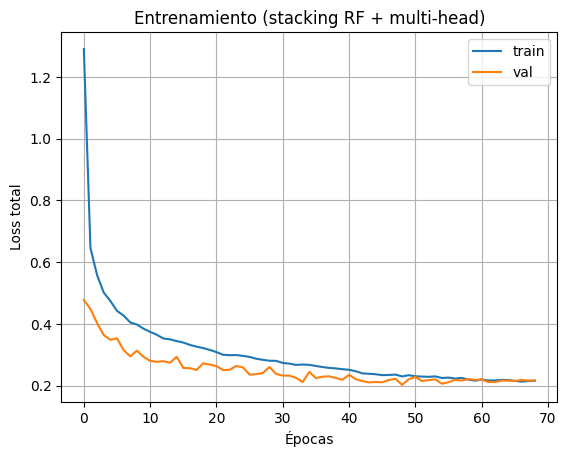

In [48]:
#----------------------------Compilación y entrenamiento----------------------------
opt = keras.optimizers.Adam(learning_rate=3e-4, clipnorm=1.0)  # Adam estable con clipping de gradiente

# Compila con pérdidas MSE (funcionan bien en log con stacking) y pesos por salida
multi.compile(
    optimizer=opt,
    loss={"y0": "mse", "y1": "mse", "y23": "mse"},  # y0,y1 en log-space; y23 en original estandarizado
    loss_weights={"y0": 2.0, "y1": 2.0, "y23": 1.0},  # más foco a y0,y1
    metrics={"y0": ["mae"], "y1": ["mae"], "y23": ["mae"]}  # mae como métrica adicional informativa
)

# Separa targets por cabeza en el espacio ya estandarizado
y0_tr,  y1_tr,  y23_tr  = Y_tr_sc[:, 0], Y_tr_sc[:, 1], Y_tr_sc[:, 2:4]  # train heads
y0_val, y1_val, y23_val = Y_val_sc[:, 0], Y_val_sc[:, 1], Y_val_sc[:, 2:4]  # val heads

# Callbacks: early stopping y reducción de LR en meseta
early   = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)  # detén si no mejora
plateau = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=8, min_lr=1e-6, verbose=1)  # baja LR

# Entrena el modelo
hist = multi.fit(
    X_tr_sc, {"y0": y0_tr, "y1": y1_tr, "y23": y23_tr},  # X train + dict de Y por cabeza
    validation_data=(X_val_sc, {"y0": y0_val, "y1": y1_val, "y23": y23_val}),  # val data
    epochs=300, batch_size=32, callbacks=[early, plateau], verbose=1  # hiperparámetros de entrenamiento
)

# Curva de pérdidas para control visual rápido
plt.figure()  # abre figura
plt.plot(hist.history["loss"], label="train")  # loss train
plt.plot(hist.history["val_loss"], label="val")  # loss val
plt.xlabel("Épocas")  # etiqueta eje x
plt.ylabel("Loss total")  # etiqueta eje y
plt.title("Entrenamiento (stacking RF + multi-head)")  # título
plt.legend(); plt.grid(True); plt.show()  # leyenda + rejilla + muestra


In [49]:
#----------------------------Predicción y métricas----------------------------
# Predice en val por cabeza
y0_hat_sc, y1_hat_sc, y23_hat_sc = multi.predict(X_val_sc, verbose=0)  # predicciones heads
Y_hat_sc = np.concatenate([y0_hat_sc, y1_hat_sc, y23_hat_sc], axis=1)  # recompón en (n,4)

# Métricas en log-space (desestandariza sin expm1 para y0,y1)
Y_val_log_estd = scaler_Y.inverse_transform(Y_val_sc.copy()).astype("float64")  # y_true en log-space
Y_hat_log_estd = scaler_Y.inverse_transform(Y_hat_sc.copy()).astype("float64")  # y_pred en log-space

# Clips prudentes en log para evitar extremos raros
for j in (0, 1):  # columnas de log
    lo, hi = Y_LOG_BOUNDS[j]["lo_log"], Y_LOG_BOUNDS[j]["hi_log"]  # límites log
    Y_val_log_estd[:, j] = np.clip(Y_val_log_estd[:, j], lo, hi)  # clip true
    Y_hat_log_estd[:, j] = np.clip(Y_hat_log_estd[:, j], lo, hi)  # clip pred

# Calcula RMSLE y R² en log para y0,y1
rmsle_y0 = np.sqrt(mean_squared_error(Y_val_log_estd[:, 0], Y_hat_log_estd[:, 0]))  # RMSLE y0
r2log_y0 = r2_score(Y_val_log_estd[:, 0], Y_hat_log_estd[:, 0])  # R² en log y0

rmsle_y1 = np.sqrt(mean_squared_error(Y_val_log_estd[:, 1], Y_hat_log_estd[:, 1]))  # RMSLE y1
r2log_y1 = r2_score(Y_val_log_estd[:, 1], Y_hat_log_estd[:, 1])  # R² en log y1

# Métricas en original para y2,y3 (invirtiendo robustamente)
Y_hat_orig = inverse_transform_predictions_robust(Y_hat_sc, scaler_Y, log_cols=(0, 1), bounds=Y_LOG_BOUNDS)  # pred en original
mae_y2  = mean_absolute_error(Y_val[:, 2], Y_hat_orig[:, 2])  # MAE y2
rmse_y2 = np.sqrt(mean_squared_error(Y_val[:, 2], Y_hat_orig[:, 2]))  # RMSE y2
r2_y2   = r2_score(Y_val[:, 2], Y_hat_orig[:, 2])  # R² y2

mae_y3  = mean_absolute_error(Y_val[:, 3], Y_hat_orig[:, 3])  # MAE y3
rmse_y3 = np.sqrt(mean_squared_error(Y_val[:, 3], Y_hat_orig[:, 3]))  # RMSE y3
r2_y3   = r2_score(Y_val[:, 3], Y_hat_orig[:, 3])  # R² y3

# Imprime resumen de métricas
print(f"y0 (log): RMSLE={rmsle_y0:.4f} | R2_log={r2log_y0:.4f}")  # reporte y0
print(f"y1 (log): RMSLE={rmsle_y1:.4f} | R2_log={r2log_y1:.4f}")  # reporte y1
print(f"y2 (orig): MAE={mae_y2:.4f} RMSE={rmse_y2:.4f} R2={r2_y2:.4f}")  # reporte y2
print(f"y3 (orig): MAE={mae_y3:.4f} RMSE={rmse_y3:.4f} R2={r2_y3:.4f}")  # reporte y3


y0 (log): RMSLE=0.8291 | R2_log=0.9927
y1 (log): RMSLE=0.3865 | R2_log=0.9382
y2 (orig): MAE=0.2551 RMSE=0.3102 R2=0.9975
y3 (orig): MAE=0.0498 RMSE=0.1019 R2=0.9847


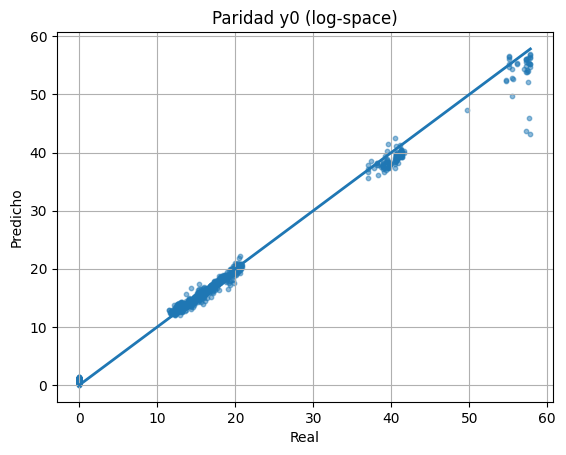

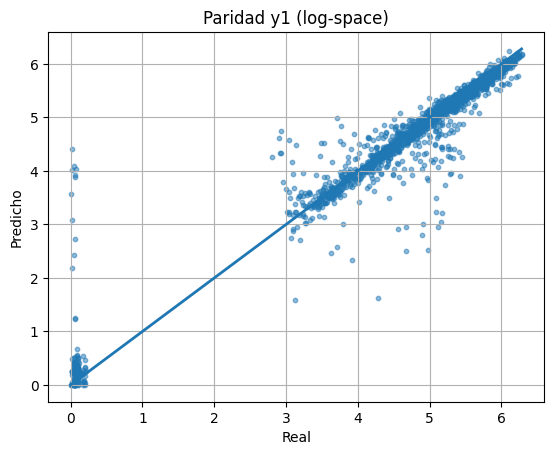

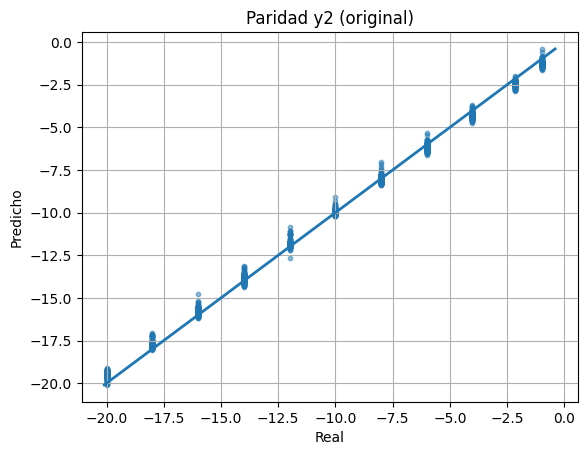

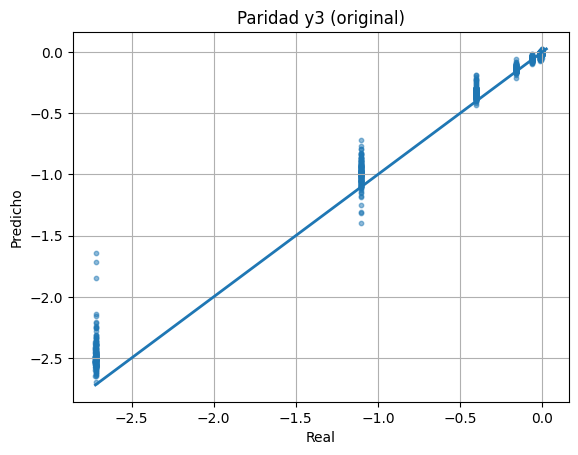

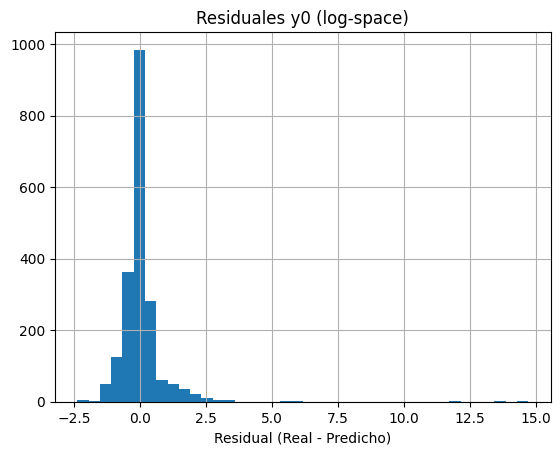

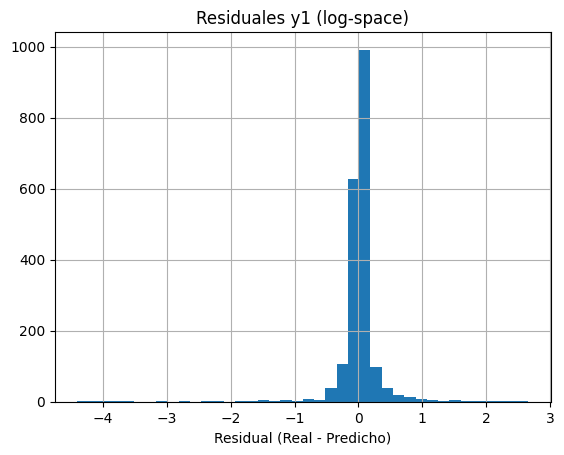

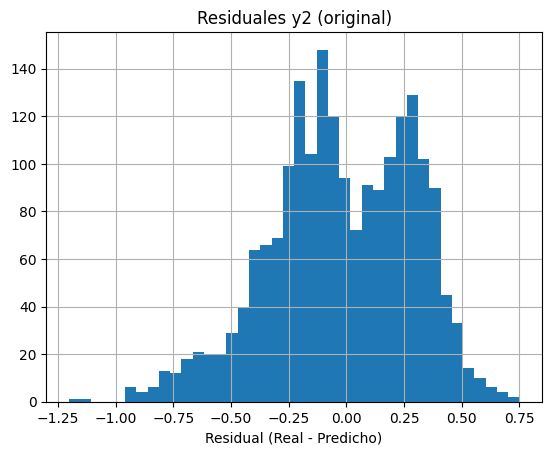

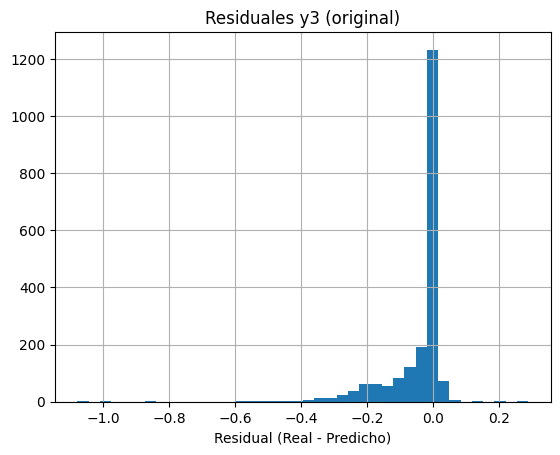

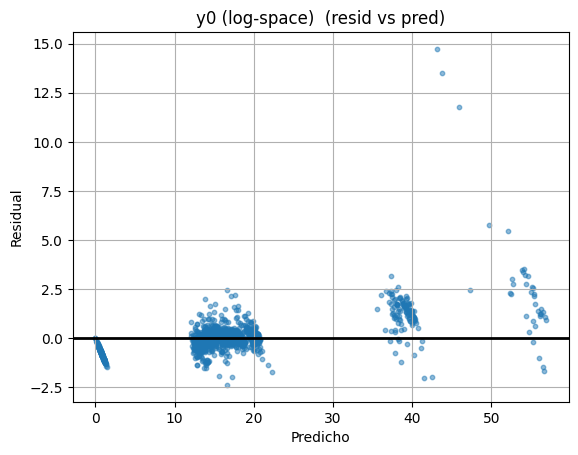

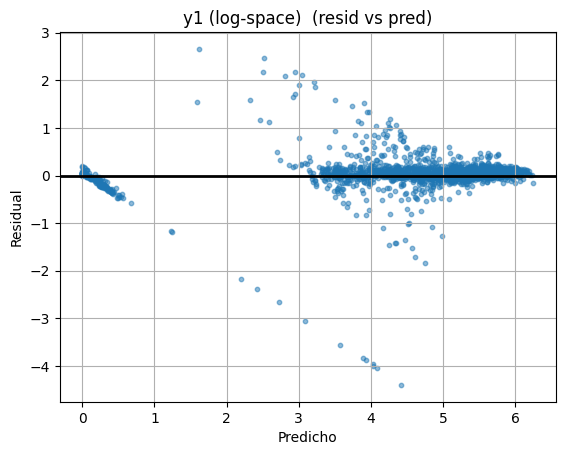

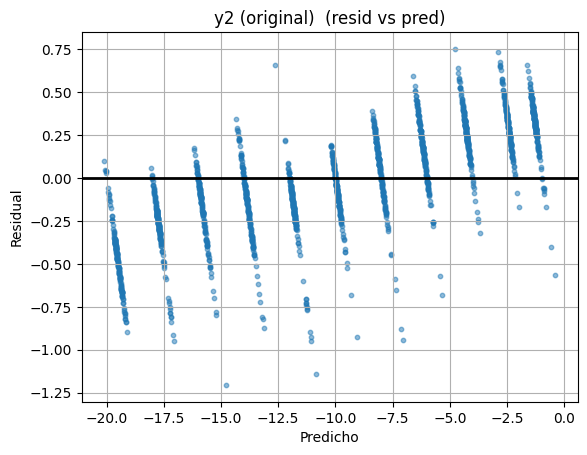

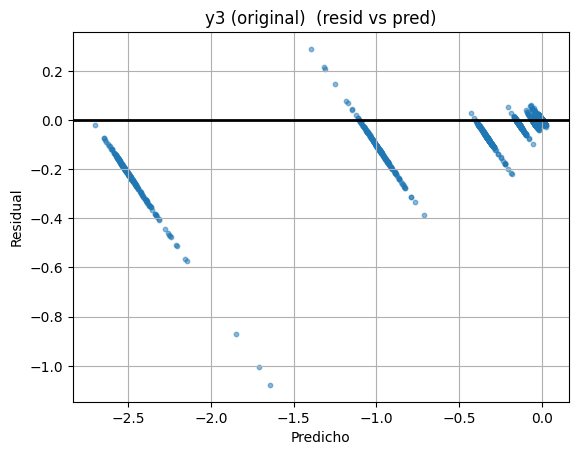

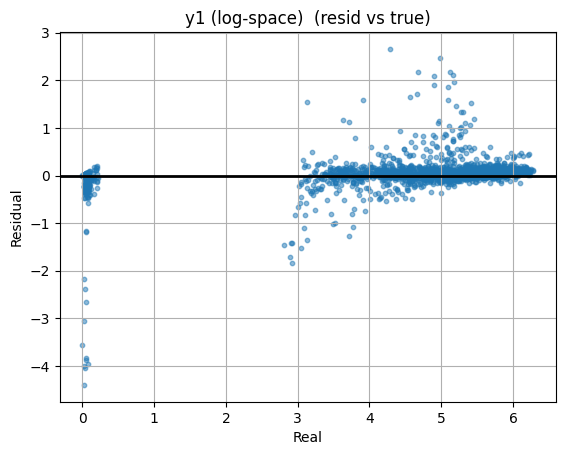

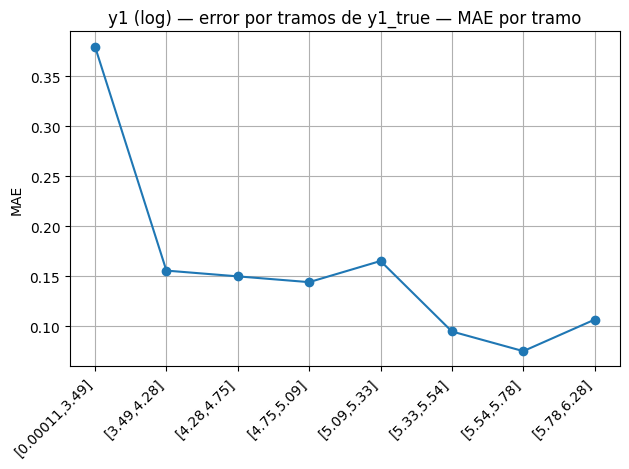

Tabla y1 (log), error por tramos [min,max], n, MAE, RMSE:
[0.000,3.494] n=250  MAE=0.3794 RMSE=0.8332
[3.494,4.277] n=250  MAE=0.1557 RMSE=0.2708
[4.277,4.748] n=250  MAE=0.1500 RMSE=0.3239
[4.748,5.086] n=250  MAE=0.1442 RMSE=0.3241
[5.086,5.329] n=250  MAE=0.1653 RMSE=0.3811
[5.329,5.536] n=250  MAE=0.0949 RMSE=0.2030
[5.536,5.780] n=250  MAE=0.0753 RMSE=0.1086
[5.780,6.282] n=250  MAE=0.1068 RMSE=0.1385


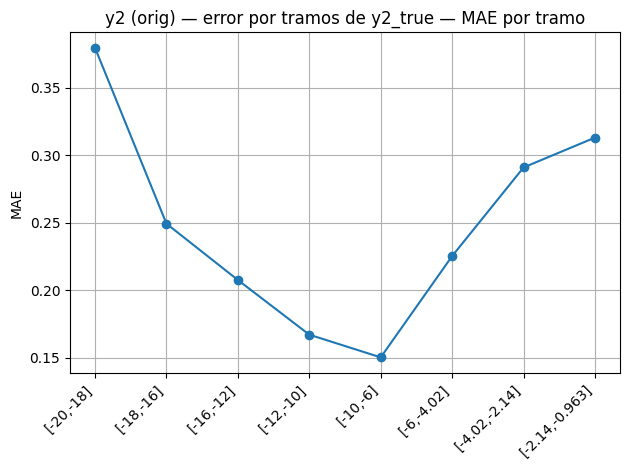


Tabla y2 (orig), error por tramos [min,max], n, MAE, RMSE:
[-20.000,-18.000] n=365  MAE=0.3797 RMSE=0.4278
[-18.000,-16.000] n=334  MAE=0.2494 RMSE=0.3093
[-16.000,-12.000] n=521  MAE=0.2077 RMSE=0.2740
[-12.000,-10.000] n=367  MAE=0.1672 RMSE=0.2357
[-10.000,-6.003] n=389  MAE=0.1504 RMSE=0.1980
[-6.003,-4.018] n=278  MAE=0.2254 RMSE=0.2609
[-4.018,-2.145] n=263  MAE=0.2911 RMSE=0.3219
[-2.145,-0.963] n=272  MAE=0.3132 RMSE=0.3366


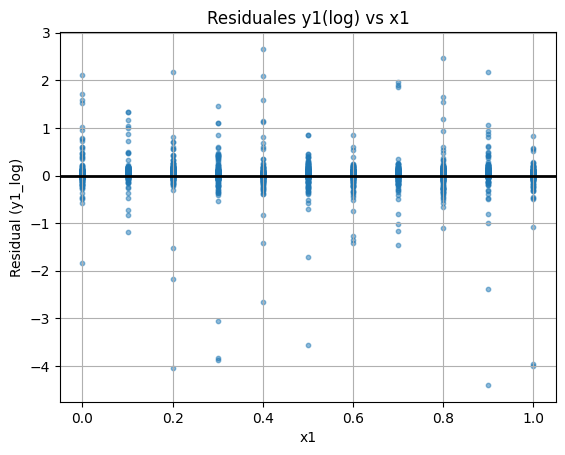

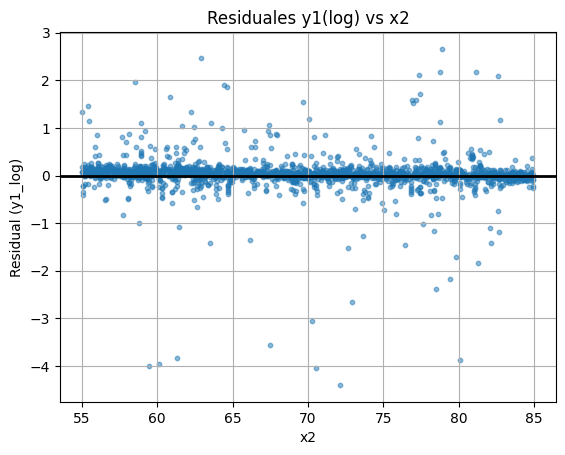

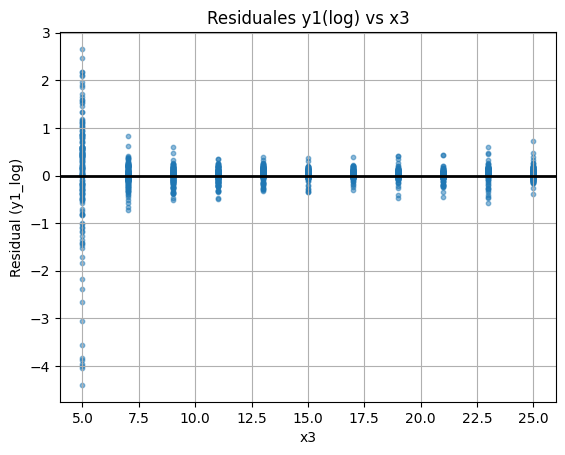

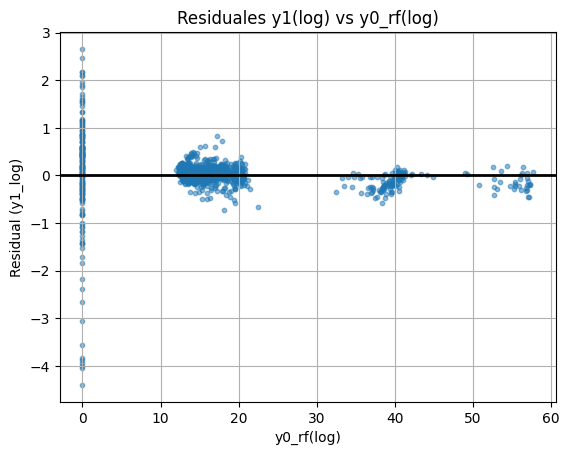

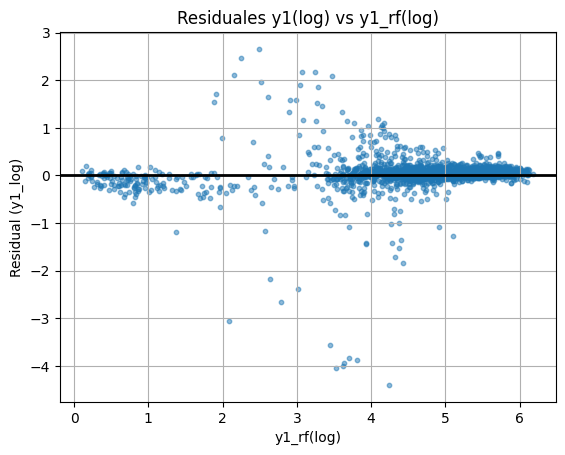

In [51]:
# ===============================
# Gráficas de diagnóstico
# ===============================


# ---------- Utilidades genéricas ----------
def parity(y_true, y_pred, title):
    """Dispersión Real vs Predicho + línea y=x."""
    lo = float(min(y_true.min(), y_pred.min()))
    hi = float(max(y_true.max(), y_pred.max()))
    plt.figure()
    plt.scatter(y_true, y_pred, s=10, alpha=0.5)
    plt.plot([lo, hi], [lo, hi], lw=2)
    plt.title(title); plt.xlabel("Real"); plt.ylabel("Predicho")
    plt.grid(True); plt.show()

def resid_hist(y_true, y_pred, title):
    """Histograma de residuales (Real - Predicho)."""
    r = y_true - y_pred
    plt.figure()
    plt.hist(r, bins=40)
    plt.title(title); plt.xlabel("Residual (Real - Predicho)")
    plt.grid(True); plt.show()

def resid_scatter(y_true, y_pred, title, xaxis="pred"):
    """
    Dispersión de residuales vs predicho (por defecto) o vs real.
    xaxis: "pred" o "true".
    """
    r = y_true - y_pred
    x = y_pred if xaxis=="pred" else y_true
    plt.figure()
    plt.scatter(x, r, s=10, alpha=0.5)
    plt.axhline(0, lw=2, color="k")
    plt.title(title + f"  (resid vs {xaxis})")
    plt.xlabel("Predicho" if xaxis=="pred" else "Real"); plt.ylabel("Residual")
    plt.grid(True); plt.show()

def error_por_tramo(x_scalar, y_true, y_pred, nbins=8, title="Error por tramos"):
    """
    Parte una variable escalar (x_scalar) en cuantiles y reporta MAE/RMSE por tramo.
    Devuelve la tabla para que puedas imprimirla si quieres.
    """
    qs = np.quantile(x_scalar, np.linspace(0,1,nbins+1))
    tabla = []
    for a,b in zip(qs[:-1], qs[1:]):
        m = (x_scalar >= a) & (x_scalar <= b)
        if m.sum() > 0:
            mae = mean_absolute_error(y_true[m], y_pred[m])
            rmse = np.sqrt(mean_squared_error(y_true[m], y_pred[m]))
            tabla.append((a,b,int(m.sum()), mae, rmse))
    # Visual rápido: MAE por tramo
    plt.figure()
    xs = [f"[{a:.3g},{b:.3g}]" for a,b,_,_,_ in tabla]
    maes = [mae for _,_,_,mae,_ in tabla]
    plt.plot(range(len(xs)), maes, marker="o")
    plt.xticks(range(len(xs)), xs, rotation=45, ha="right")
    plt.title(title + " — MAE por tramo"); plt.ylabel("MAE"); plt.grid(True); plt.tight_layout(); plt.show()
    return tabla

# ---------- Preparar arrays en las escalas correctas ----------
# y0,y1 en LOG-SPACE (desestandarizados, SIN expm1), con clips prudentes:
Y_val_log_estd = scaler_Y.inverse_transform(Y_val_sc.copy()).astype("float64")
Y_hat_log_estd = scaler_Y.inverse_transform(Y_hat_sc.copy()).astype("float64")
for j in (0,1):
    lo, hi = Y_LOG_BOUNDS[j]["lo_log"], Y_LOG_BOUNDS[j]["hi_log"]
    Y_val_log_estd[:, j] = np.clip(Y_val_log_estd[:, j], lo, hi)
    Y_hat_log_estd[:, j] = np.clip(Y_hat_log_estd[:, j], lo, hi)

# y2,y3 en ORIGINAL (ya tienes Y_hat_orig y Y_val en original)
y2_true, y2_pred = Y_val[:,2], Y_hat_orig[:,2]
y3_true, y3_pred = Y_val[:,3], Y_hat_orig[:,3]

# ---------- 1) Paridad ----------
parity(Y_val_log_estd[:,0], Y_hat_log_estd[:,0], "Paridad y0 (log-space)")
parity(Y_val_log_estd[:,1], Y_hat_log_estd[:,1], "Paridad y1 (log-space)")
parity(y2_true, y2_pred, "Paridad y2 (original)")
parity(y3_true, y3_pred, "Paridad y3 (original)")

# ---------- 2) Distribución de residuales ----------
resid_hist(Y_val_log_estd[:,0], Y_hat_log_estd[:,0], "Residuales y0 (log-space)")
resid_hist(Y_val_log_estd[:,1], Y_hat_log_estd[:,1], "Residuales y1 (log-space)")
resid_hist(y2_true, y2_pred, "Residuales y2 (original)")
resid_hist(y3_true, y3_pred, "Residuales y3 (original)")

# ---------- 3) Residuales vs Predicho (y vs Real) ----------
resid_scatter(Y_val_log_estd[:,0], Y_hat_log_estd[:,0], "y0 (log-space)", xaxis="pred")
resid_scatter(Y_val_log_estd[:,1], Y_hat_log_estd[:,1], "y1 (log-space)", xaxis="pred")
resid_scatter(y2_true, y2_pred, "y2 (original)", xaxis="pred")
resid_scatter(y3_true, y3_pred, "y3 (original)", xaxis="pred")

# (Opcional) también contra el valor real:
resid_scatter(Y_val_log_estd[:,1], Y_hat_log_estd[:,1], "y1 (log-space)", xaxis="true")

# ---------- 4) Error por tramos (cuantiles) ----------
# y1 en log-space por tramos de su propio valor real (para ver dónde falla):
tabla_y1 = error_por_tramo(Y_val_log_estd[:,1], Y_val_log_estd[:,1], Y_hat_log_estd[:,1],
                           nbins=8, title="y1 (log) — error por tramos de y1_true")
print("Tabla y1 (log), error por tramos [min,max], n, MAE, RMSE:")
for a,b,n,mae,rmse in tabla_y1:
    print(f"[{a:.3f},{b:.3f}] n={n:<4d} MAE={mae:.4f} RMSE={rmse:.4f}")

# y2 (original) por tramos de y2_true:
tabla_y2 = error_por_tramo(y2_true, y2_true, y2_pred, nbins=8, title="y2 (orig) — error por tramos de y2_true")
print("\nTabla y2 (orig), error por tramos [min,max], n, MAE, RMSE:")
for a,b,n,mae,rmse in tabla_y2:
    print(f"[{a:.3f},{b:.3f}] n={n:<4d} MAE={mae:.4f} RMSE={rmse:.4f}")

# ---------- 5) Residuales vs features de entrada ----------
# Útil para detectar heterocedasticidad o patrones no capturados.
# Usamos X_val_raw (en unidades originales) y también las features del profesor (y0_val_rf, y1_val_rf).
resid_y1_log = Y_val_log_estd[:,1] - Y_hat_log_estd[:,1]  # residuales de y1 en log
labels_x = ["x1","x2","x3","y0_rf(log)","y1_rf(log)"]     # nombres para ejes/título
Xv_aug_for_plot = np.column_stack([X_val_raw, y0_val_rf.reshape(-1,1), y1_val_rf.reshape(-1,1)])  # concatena

for j in range(Xv_aug_for_plot.shape[1]):
    plt.figure()
    plt.scatter(Xv_aug_for_plot[:,j], resid_y1_log, s=10, alpha=0.5)
    plt.axhline(0, lw=2, color="k")
    name = labels_x[j] if j < len(labels_x) else f"feat{j}"
    plt.title(f"Residuales y1(log) vs {name}")
    plt.xlabel(name); plt.ylabel("Residual (y1_log)")
    plt.grid(True); plt.show()
